In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier

# needs numpy < 2.4 and restart kernel to clear cache
import shap

In [11]:
customer_df = pd.read_csv('../data/customers.csv', parse_dates=["signup_date"])
print(customer_df.head(10))

  customer_id signup_date  true_lifetime_days
0      C00000  2025-08-22                 204
1      C00001  2025-03-07                 365
2      C00002  2025-08-18                  48
3      C00003  2025-09-22                  84
4      C00004  2025-05-28                 113
5      C00005  2025-11-12                 120
6      C00006  2025-08-22                 117
7      C00007  2025-08-03                 321
8      C00008  2025-05-02                 209
9      C00009  2025-01-06                 172


In [12]:
transaction_df = pd.read_csv('../data/transactions.csv', parse_dates=["transaction_date"])
print(transaction_df.head(10))

  customer_id transaction_date  amount
0      C00000       2025-09-10  195.78
1      C00000       2025-09-12   50.87
2      C00000       2025-10-01  133.25
3      C00000       2025-10-16   37.44
4      C00000       2025-10-18  101.95
5      C00000       2025-10-28  195.22
6      C00000       2025-11-23  206.80
7      C00000       2025-11-27   79.74
8      C00000       2025-12-09   85.42
9      C00000       2025-12-27   47.99


# Churn Prediction as Classification
Churn = yes/no trong T tháng tới

Yêu cầu

● Define churn label (30 / 60 / 90 ngày)

● Feature engineering:
○ RFM
○ Frequency trend

● Train model (Logistic / Tree)

Deliverable
● AUC, Precision–Recall
● Confusion matrix
● Top features

## Visualize churn behaviours

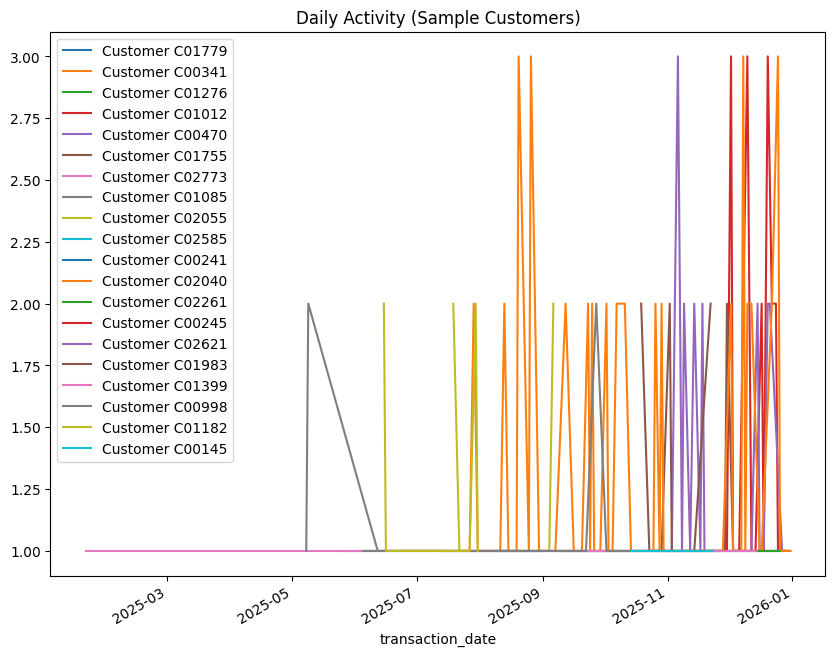

In [13]:
# Check churn behaviours
sample_customer = customer_df.sample(20, random_state=10)["customer_id"]
plt.figure(figsize=(10, 8))
for cid in sample_customer:
    hist = transaction_df[transaction_df["customer_id"] == cid]
    daily = hist.groupby("transaction_date").size()
    daily.plot(label=f"Customer {cid}")

plt.legend()
plt.title("Daily Activity (Sample Customers)")
plt.show()

In [14]:
# Define cutoff date
CUTOFF_DATE = pd.Timestamp("2025-11-01")
PRED_WINDOW = 60

def label_churn(transaction_df, CUTOFF_DATE, PRED_WINDOW=30):
    future = transaction_df[(transaction_df["transaction_date"] > CUTOFF_DATE)
                            & (transaction_df["transaction_date"] <= CUTOFF_DATE + pd.Timedelta(days=PRED_WINDOW))]
    # Defince active customers after window
    active_customers = future["customer_id"].unique()
    # Aggregate old customers
    labels = transaction_df[transaction_df["transaction_date"] <= CUTOFF_DATE][["customer_id"]].drop_duplicates()
    labels["churn_60d"] = ~labels["customer_id"].isin(active_customers)
    return labels

labels = label_churn(transaction_df, CUTOFF_DATE, PRED_WINDOW).reset_index().drop(columns=["index"])

labels.head()

,customer_id,churn_60d
0,C00000,False
1,C00001,False
2,C00002,True
3,C00003,False
4,C00004,True


## Feature engineering

In [15]:
def build_features(df, cutoff_date):
    hist = df[df["transaction_date"] <= cutoff_date]

    agg = hist.groupby("customer_id").agg(
        recency_days=("transaction_date", lambda x: (cutoff_date - x.max()).days))
    
    windows = [30, 45, 60, 75, 90]
    for w in windows:
        agg[f"freq_{w}d"] = hist.groupby("customer_id")["transaction_date"].apply(
            lambda x: (x >= cutoff_date - pd.Timedelta(days=w)).sum())
        agg[f"monetary_{w}d"] = hist.groupby("customer_id").apply(
            lambda x: x[x["transaction_date"] >= cutoff_date - pd.Timedelta(days=w)]["amount"].sum())
    for w in windows:
        agg[f"freq_ratio_{w}_90"] = agg[f"freq_{w}d"] / (agg["freq_90d"] + 1e-6)
    
    return agg.reset_index()

features = build_features(transaction_df, CUTOFF_DATE)
data = features.merge(labels, on="customer_id")

data.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_34708\797579684.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg[f"monetary_{w}d"] = hist.groupby("customer_id").apply(
C:\Users\Admin\AppData\Local\Temp\ipykernel_34708\797579684.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg[f"monetary_{w}d"] = hist.groupby("customer_id").apply(
C:\Users\Admin\AppData\Local\Temp\ipykernel_34708\797579684.py:11: FutureWar

,customer_id,recency_days,freq_30d,monetary_30d,freq_45d,monetary_45d,freq_60d,monetary_60d,freq_75d,monetary_75d,freq_90d,monetary_90d,freq_ratio_30_90,freq_ratio_45_90,freq_ratio_60_90,freq_ratio_75_90,freq_ratio_90_90,churn_60d
0,C00000,4,3,334.61,4,467.86,6,714.51,6,714.51,6,714.51,0.50,0.666667,1.000000,1.000000,1.0,False
1,C00001,25,3,138.14,3,138.14,4,173.59,4,173.59,4,173.59,0.75,0.750000,1.000000,1.000000,1.0,False
2,C00002,36,0,0.00,1,115.78,5,289.84,11,910.64,11,910.64,0.00,0.090909,0.454545,1.000000,1.0,True
3,C00003,27,2,79.68,2,79.68,2,79.68,2,79.68,2,79.68,1.00,1.000000,1.000000,1.000000,1.0,False
4,C00004,48,0,0.00,0,0.00,2,152.14,2,152.14,6,567.51,0.00,0.000000,0.333333,0.333333,1.0,True


In [16]:
# Rather balanced data
data["churn_60d"].value_counts()

churn_60d
True     1401
False    1143
Name: count, dtype: int64

In [23]:
# Step 1: Split data
train_df = data[data["customer_id"].isin(data["customer_id"].sample(frac=0.7, random_state=10))]
test_df = data[~data["customer_id"].isin(train_df["customer_id"])]

X_train = train_df.drop(columns=["customer_id", "churn_60d"])
y_train = train_df["churn_60d"].astype(int).values

X_test = test_df.drop(columns=["customer_id", "churn_60d"])
y_test = test_df["churn_60d"].astype(int).values

In [48]:
# Step 2: Train a XGB Classifier model
forest = XGBClassifier(
    n_estimators=300,       # number of trees in the forest
    max_depth=2,            # limit tree depth to avoid overfitting
    min_samples_leaf=2,     # min samples allowed in a leaf
    random_state=10
)

forest.fit(X_train, y_train)

# Step 3: Evaluate on the training set
print("\nACCURACY FOR THE TRAINING SET")
y_pred_train = forest.predict(X_train)
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))

# Step 4: Feature Importance
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": forest.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance:\n", importance_df)


ACCURACY FOR THE TRAINING SET
Accuracy: 0.9606962380685008

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       784
           1       0.97      0.96      0.96       997

    accuracy                           0.96      1781
   macro avg       0.96      0.96      0.96      1781
weighted avg       0.96      0.96      0.96      1781


Feature Importance:
              Feature  Importance
11  freq_ratio_30_90    0.546580
0       recency_days    0.081549
14  freq_ratio_75_90    0.071051
1           freq_30d    0.068585
13  freq_ratio_60_90    0.043835
12  freq_ratio_45_90    0.024178
2       monetary_30d    0.022863
5           freq_60d    0.020920
10      monetary_90d    0.020790
8       monetary_75d    0.019409
9           freq_90d    0.018142
3           freq_45d    0.017764
4       monetary_45d    0.016537
6       monetary_60d    0.015284
7           freq_75d    0.012513
15  freq_ratio_90_90    0.000000



ACCURACY FOR THE TEST SET
Accuracy: 0.8597640891218873

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       359
           1       0.87      0.87      0.87       404

    accuracy                           0.86       763
   macro avg       0.86      0.86      0.86       763
weighted avg       0.86      0.86      0.86       763



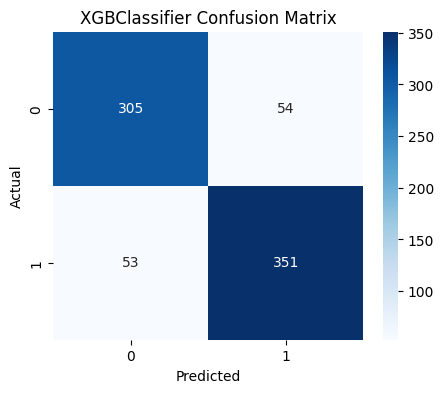

ROC-AUC score for test data: 0.9328994180755122


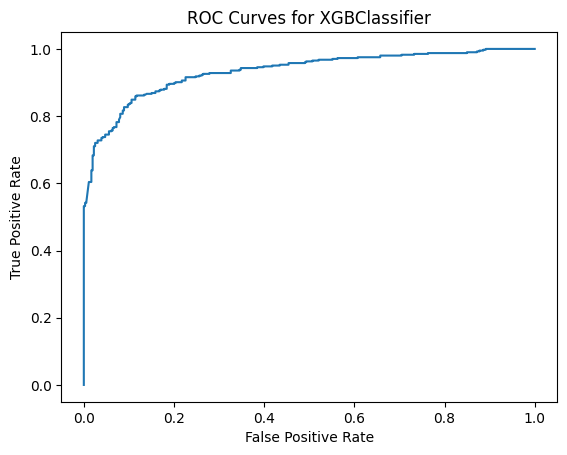

In [63]:
# Step 5: Evaluate on the test set
print("\nACCURACY FOR THE TEST SET")
y_pred_test = forest.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

# Step 6. Visualize the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBClassifier Confusion Matrix')
plt.show()

# Step 7. Calculate ROC-AUC score
y_pred_proba = forest.predict_proba(X_test)[:, 1] # select churn class
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"ROC-AUC score for test data: {auc_score}")

# Step 8: Visualiza curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'{forest} (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for XGBClassifier')
plt.show()


## SHAP Explanability

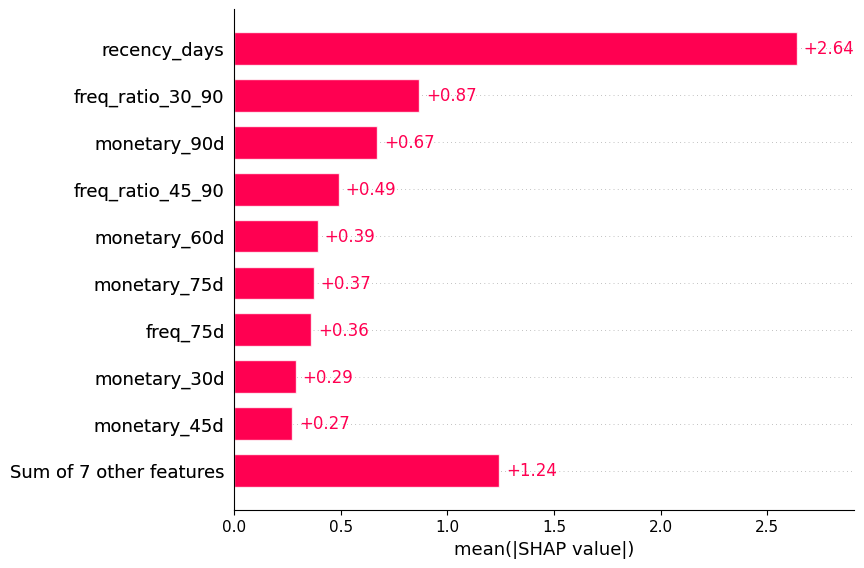

In [54]:
background_adult = shap.maskers.Independent(X_train, max_samples=100)
explainer = shap.Explainer(forest, background_adult)
shap_values = explainer(X_train, check_additivity=False)

plt.figure(figsize=(10, 20))
# Show all features by setting max_display to None
shap.plots.bar(shap_values)